# Setup

In [1]:
import os
import csv
from datetime import datetime
import getpass
import pyodbc
import xlrd
import arcpy
from arcgis.gis import GIS
from arcgis.mapping import WebMap
from arcgis.features import FeatureSet, GeoAccessor, GeoSeriesAccessor, FeatureLayer
import pickle
import pandas as pd
import numpy as np
import matplotlib
import cufflinks as cf
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [201]:
# pandas settings
pd.options.plotting.backend = "plotly"
# set data frame display options
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:,.2f}'.format

# set overwrite to true
arcpy.env.overwriteOutput = True

# in memory output file path
wk_memory = "memory/"

# set workspace and sde connections 
scratchFolder = "C:\\GIS\\PROJECT\\ScratchPaper"

workspace     = "C:\\Users\\mbindl\\Documents\\GitHub\\ThresholdEvaluation"
arcpy.env.workspace = "C:\\GIS\\PROJECT\\ScratchPaper\\ScratchPaper.gdb"

## SDE Connection Files saved on the Network
# sdeTabular = "F:\\GIS\\GIS_DATA\\Tabular.sde"
# sdeBase    = "F:\\GIS\\GIS_DATA\\Vector.sde"
# sdeCollect = "F:\\GIS\\GIS_DATA\\Collect.sde"

# network path to connection files
filePath = "C:\\GIS\\DB_CONNECT"

# database file path 
sdeBase = os.path.join(filePath, "Vector.sde")
sdeCollect = os.path.join(filePath, "Collection.sde")

# set style variables
template = 'plotly_white'
font     = 'Calibri'

## Style

### LT Info Style Guide
Last Updated May 2019
### Fonts
* Open Sans (https://fonts.google.com/specimen/Open+Sans)

#### All text, navigation and labels
* Montserrat (https://fonts.google.com/specimen/Montserrat)

#### Headers and page titles
* FF Meta Serif (https://fonts.adobe.com/fonts/ff-meta-serif)

### Base Maps
* Terrain: ESRI World Topo Map https://www.arcgis.com/home/item.html?id=30e5fe3149c34df1ba922e6f5bbf808f
* Aerial: ESRI World Imagery https://www.arcgis.com/home/item.html?id=10df2279f9684e4a9f6a7f08febac2a9
* Street: ESRI World Street Map https://www.arcgis.com/home/item.html?id=3b93337983e9436f8db950e38a8629af
#### Other Options
* https://api.mapbox.com/styles/v1/mtbindl/cjpm66f7x1kf32spdpfdyyxs3.html?fresh=true&title=view&access_token=pk.eyJ1IjoibXRiaW5kbCIsImEiOiJjanMzcXljcXEwNHJkNDlwZno3dWo5a2UxIn0.qynnCUslq3GOpWprfjfDrg
* https://api.mapbox.com/styles/v1/mtbindl/cjwrcl3jh1m6h1cp2p7o8kxu2.html?fresh=true&title=view&access_token=pk.eyJ1IjoibXRiaW5kbCIsImEiOiJjanMzcXljcXEwNHJkNDlwZno3dWo5a2UxIn0.qynnCUslq3GOpWprfjfDrg
* https://api.mapbox.com/styles/v1/mtbindl/ckawwcj4701wt1iqa2f5w0zz5.html?fresh=true&title=view&access_token=pk.eyJ1IjoibXRiaW5kbCIsImEiOiJjanMzcXljcXEwNHJkNDlwZno3dWo5a2UxIn0.qynnCUslq3GOpWprfjfDrg#9.24/39.0708/-120.1807


Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']


In [38]:
template = 'plotly_white'
font     = 'Calibri'

## Color

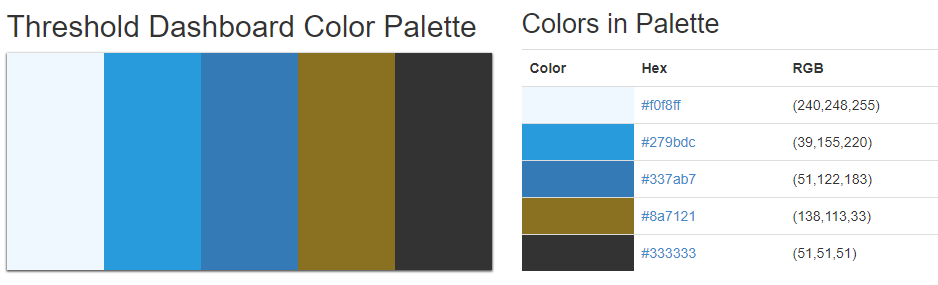

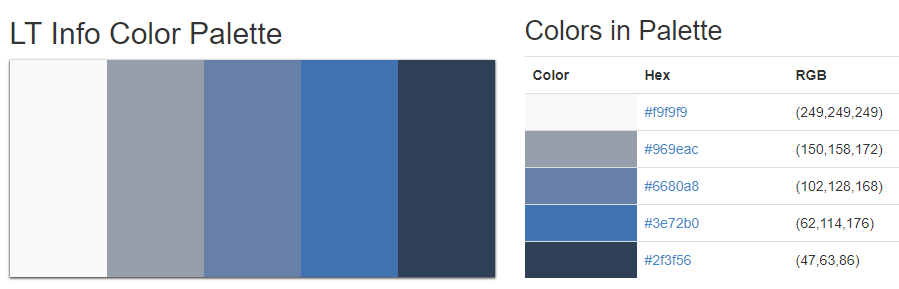

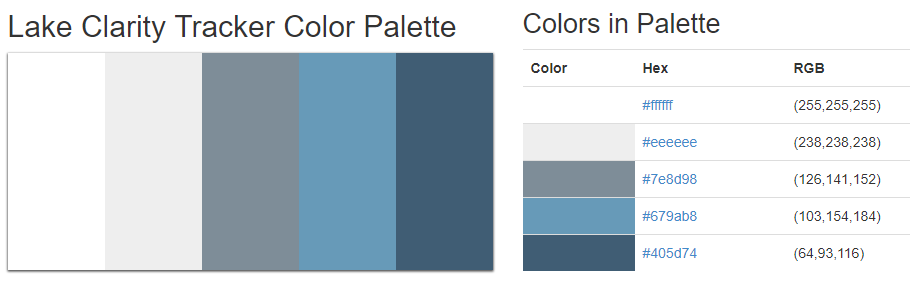

### Color Codes
#### Threshold Dashboard Color Pallette
#f0f8ff
#279bdc
#337ab7
#8a7121
#333333

#### LTInfo Color Pallette
#f9f9f9
#969eac
#6680a8
#3e72b0
#2f3f56

#### Lake Clarity Tracker Color Pallette
#ffffff
#eeeeee
#7e8d98
#679ab8
#405d74

#### Color Brewer 
###### Sequential
* https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=9
* #fff7fb
* #ece7f2
* #d0d1e6
* #a6bddb
* #74a9cf
* #3690c0
* #0570b0
* #045a8d
* #023858

###### Diverging
* https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=10
* #543005
* #8c510a
* #bf812d
* #dfc27d
* #f6e8c3
* #c7eae5
* #80cdc1
* #35978f
* #01665e
* #003c30

###### Qaulitative
* https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=10
* #a6cee3
* #1f78b4
* #b2df8a
* #33a02c
* #fb9a99
* #e31a1c
* #fdbf6f
* #ff7f00
* #cab2d6
* #6a3d9a

In [ ]:
color_discrete_map = {'a': '#a6cee3', 
                      'b': '#1f78b4', 
                      'c': '#b2df8a',
                      'd': '#33a02c',
                      'e': '#fb9a99',
                      'f': '#e31a1c',
                      'g': '#fdbf6f',
                      'h': '#ff7f00',
                      'i': '#cab2d6'}

## Web GIS Setup

In [5]:
# login to AGOL
username = input("Username: ")
password = getpass.getpass("Password: ")
Portal = GIS("https://maps.trpa.org/portal", username, password)
print("Successfully logged in to {} as {}".format(Portal.properties.portalName, 
                                                  Portal.users.me.username))



Username: mbindl
Password: ········
Successfully logged in to ArcGIS Enterprise as mbindl


# Air Quality

## Data

In [5]:
workspace = "F:\\Research and Analysis\\Threshold reporting\\ThresholdData\\Air Quality"

In [5]:
airExcel = r"F:\Research and Analysis\Threshold reporting\ThresholdData\Air Quality\IndicatorValuesTable.xlsx"
xls = xlrd.open_workbook(airExcel, on_demand=True)
print (xls.sheet_names()) # <- remeber: xlrd sheet_names is a function, not a property

dfAir = pd.read_excel(airExcel, sheet_name=0)
dfAir['Beta'] = np.nan
dfAir

['IVtable']


,Indicator,Pollutant,Statistic,Year,Data?,Site,Value,Data Source,Exceedances,Threshold Value,Percent of Threshold Value,Include in Trend Analysis?,Beta
0,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,1993,Yes,South Lake Tahoe Sandy Way,3.30,EPA Air Data,0.00,nan,nan,NaN,nan
1,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,1994,Yes,South Lake Tahoe Sandy Way,2.60,EPA Air Data,0.00,nan,nan,NaN,nan
2,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,1995,Yes,South Lake Tahoe Sandy Way,2.60,EPA Air Data,0.00,nan,nan,NaN,nan
3,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,1996,Yes,South Lake Tahoe Sandy Way,2.40,EPA Air Data,0.00,nan,nan,NaN,nan
4,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,1997,Yes,South Lake Tahoe Sandy Way,2.40,EPA Air Data,0.00,nan,nan,NaN,nan
5,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,1998,Yes,South Lake Tahoe Sandy Way,2.30,EPA Air Data,0.00,nan,nan,NaN,nan
6,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,1999,Yes,South Lake Tahoe Sandy Way,2.30,EPA Air Data,0.00,nan,nan,NaN,nan
7,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,2000,Yes,South Lake Tahoe Sandy Way,1.80,EPA Air Data,0.00,nan,nan,NaN,nan
8,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,2001,Yes,South Lake Tahoe Sandy Way,1.90,EPA Air Data,0.00,nan,nan,NaN,nan
9,CO - 2ND HIGH 8 HR,CO,2nd High 8 Hr,2002,Yes,South Lake Tahoe Sandy Way,3.00,EPA Air Data,0.00,nan,nan,NaN,nan


In [6]:
dfAir['Indicator'].unique()

array(['CO - 2ND HIGH 8 HR', 'CO - HIGH 1 HR', 'CO - HIGH 8 HR',
       'NO2 - 98% 1 HR', 'NO2 - ANNUAL AVG.', 'NO2 - HIGH 1 HR',
       'O3 - 3 YR AVG. 4TH HIGH 8 HR', 'O3 - HIGH 1 HR', 'O3 - HIGH 8 HR',
       'PM10 - ANNUAL AVG.', 'PM10 - HIGH 24 HR',
       'PM2.5 - 3 YR AVG. 98% 24 HR', 'PM2.5 - ANNUAL AVG.',
       'PM2.5 - HIGH 24 HR',
       '3-year mean ("Average Days", 50th Percentile)',
       '3-year mean ("Worst Days", 90th Percentile)'], dtype=object)

In [7]:
dfAir['Site'].unique()

array(['South Lake Tahoe Sandy Way', 'South Lake Tahoe Tahoe Blvd',
       'Stateline Harveys', 'Stateline Horizon', 'Tahoe City',
       'Stateline TRPA', 'Cave Rock', 'Incline Village/Crystal Bay',
       'South Lake Tahoe Airport', 'Lake Tahoe Basin', 'Kings Beach',
       'DL Bliss State Park', 'Lake Tahoe CC', 'SOLA', 'LTCC'],
      dtype=object)

In [14]:
# set colors
color_discrete_map = {'Cave Rock': '#33a02c',
                      'DL Bliss State Park': '#1f78b4', 
                      'Incline Village/Crystal Bay': '#fb9a99',
                      'Kings Beach': '#e31a1c',
                      'Lake Tahoe Basin': '#ff7f00',
                      'Lake Tahoe CC': '#ff7f00',
                      'LTCC': '#ff7f00',
                      'SOLA': '#a6cee3', 
                      'South Lake Tahoe Airport': '#b2df8a', 
                      'South Lake Tahoe Sandy Way': '#b2df8a',
                      'South Lake Tahoe Tahoe Blvd': '#b2df8a',
                      'Stateline Harveys':'#cab2d6',
                      'Stateline Horizon': '#cab2d6',
                      'Stateline TRPA': '#cab2d6',
                      'Tahoe City': '#fdbf6f'                    
                        }

## Map

In [ ]:
webmap_search = AGOL.content.search(query="Threshold Evaluation Base Map", item_type="Web Map")
webmap_search
webmap = webmap_search[0]
webmap

<Item title:"Threshold Evaluation Base Map" type:Web Map owner:mbindl>
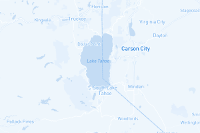

In [31]:
webmap_search = AGOL.content.search(query="Threshold Evaluation Base Map", item_type="Web Map")
webmap_search
webmap = webmap_search[0]
webmap

In [51]:
air_item = FeatureLayer("https://maps.trpa.org/server/rest/services/LTInfo_Monitoring/MapServer/16")

# display map
tvalMap = WebMap(webmap)
tvalMap.add_layer(air_item)

webmap_item_properties = {'title':'Threshold Evaluation - Air Quality',
                         'snippet':'Map created to display the locations of air quality stations in the Tahoe Basin',
                         'tags':['Air Quality', 'TRPA', 'Threshold Evaluation']}

tvalMap.save(webmap_item_properties)

for layer in tvalMap.layers:
    layer['visibility'] = True
tvalMap.update()
tvalMap

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

## Annual Average Pm2.5 Concentration

In [98]:

# set indicator
indicator = 'PM2.5 - ANNUAL AVG.'
# limit rows to indicator
dfPM25 = dfAir.loc[dfAir['Indicator'] == indicator]
# correct threshold value errors
dfPM25['Threshold Value'] = 12

# setup dataframe
df = dfPM25

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} ppm')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} ppm<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title="PM 2.5 - Annual Average Concentration",
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[0, 15],
                        title_text='Value (ppm)'
                    )
                  
                 )


# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_AnnualPM25.html"))

Beta = -0.10188799072774929


## 24-Hour Pm2.5 Concentration

In [99]:
# set indicator
indicator = 'PM2.5 - HIGH 24 HR'

# limit rows to indicator
df24PM25 = dfAir.loc[dfAir['Indicator'] == indicator]
df = df24PM25

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} ppm')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} ppm<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title="PM 2.5 - Highest 24 hour Concentration",
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 25,
                        range=[0, 150],
                        title_text='Value (ppm)'
                    )
                  
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_24hrPM25.html"))

Beta = 1.569664929972367


## Annual Average Pm10 Concentration

In [100]:
# set indicator
indicator = 'PM10 - ANNUAL AVG.'

# limit rows to indicator
dfPM10 = dfAir.loc[dfAir['Indicator'] == indicator]
dfPM10['Threshold Value'] = 20
df = dfPM10

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} ppm')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} ppm<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title="PM 10 - Average Annual Concentration",
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[0, 30],
                        title_text='Value (ppm)'
                    )
                  
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_AnnualPM10.html"))

Beta = -0.3467712989068791


## Highest 24-Hour Average Pm10 Concentration

In [101]:
# set indicator
indicator = 'PM10 - HIGH 24 HR'

# limit rows to indicator
df24PM10 = dfAir.loc[dfAir['Indicator'] == indicator]
df24PM10['Threshold Value'] = 50
df = df24PM10

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} ppm')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} ppm<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title="PM 10 - Highest 24 hour Concentration",
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 25,
                        range=[0, 200],
                        title_text='Value (ppm)'
                    )
                  
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_24hrPM10.html"))

Beta = 0.8324002436839818


## Highest 1-Hour Average Concentration Of Ozone

In [102]:
# set indicator
indicator = 'O3 - HIGH 1 HR'

# limit rows to indicator
df1HRO3 = dfAir.loc[dfAir['Indicator'] == indicator]
df = df1HRO3

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} ppm')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} ppm<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title="Ozone - 1 hour Average Concentration",
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 0.01,
                        range=[0.06, 0.11],
                        title_text='Value (ppm)'
                    )
                  
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_1hrOzone.html"))

Beta = -0.0005085079393957878


## Highest 8-Hour Average Concentration Of Carbon Monoxide

In [103]:
# set indicator
indicator = 'CO - HIGH 8 HR'

# limit rows to indicator
df8HRCO = dfAir.loc[dfAir['Indicator'] == indicator]
df = df8HRCO

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} ppm')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} ppm<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title="Carbon Monoxide - 8 hour Average Concentration",
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1,
                        range=[0, 10],
                        title_text='Value (ppm)'
                    )
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_8hrCO.html"))

Beta = -0.0834604135555978


## Regional Visibility 50Th Percentile ("Average Visibility Days") Bliss State Park

In [104]:
# set indicator

# limit rows to indicator
dfVis50th = dfAir.loc[(dfAir['Indicator'] == '3-year mean ("Average Days", 50th Percentile)')&
                      (dfAir['Pollutant'] == 'Regional Visibility')]
df = dfVis50th

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} days')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} days<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title='Regional Visibility 50th Percentile ("Average Visibility Days") DL Bliss State Park',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[0, 50],
                        title_text='Value (days)'
                    )
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_RegVis50th_Bliss.html"))

Beta = -0.46572598427297296


## Regional Visibility 90Th Percentile ("Worst Visibility Days") Bliss State Park 

In [105]:
# set indicator

# limit rows to indicator
dfVis90th = dfAir.loc[(dfAir['Indicator'] == '3-year mean ("Worst Days", 90th Percentile)')&
                      (dfAir['Pollutant'] == 'Regional Visibility')]
df = dfVis90th

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} days')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} days<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title='Regional Visibility 90th Percentile ("Worst Visibility Days") DL Bliss State Park',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[0, 50],
                        title_text='Value (days)'
                    )
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_RegVis90th_Bliss.html"))

Beta = -0.11397019053711543


## Sub-Regional Visibility 50th Percentile ("Average Visibility Days") South Lake

In [106]:
# set indicator

# limit rows to indicator
dfVisSub50th = dfAir.loc[(dfAir['Indicator'] == '3-year mean ("Average Days", 50th Percentile)')&
                      (dfAir['Pollutant'] == 'Sub-Regional Visibility')]
df = dfVisSub50th

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} days')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} days<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title='Sub-Regional Visibility 50th Percentile ("Average Visibility Days") South Lake Tahoe',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[0, 60],
                        title_text='Value (days)'
                    )
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_SubRegVis50th_SouthLake.html"))

Beta = -1.0591761811779064


## Sub-Regional Visibility 90th Percentile ("Worst Visibility Days") South Lake

In [107]:
# set indicator

# limit rows to indicator
dfVisSub90th = dfAir.loc[(dfAir['Indicator'] == '3-year mean ("Worst Days", 90th Percentile)')&
                      (dfAir['Pollutant'] == 'Sub-Regional Visibility')]
df = dfVisSub90th

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 hover_data={'Year':False, # remove year from hover data
                             'Value':':.2f'
                             })

fig.update_traces(hovertemplate='<br>%{y:.2f} days')


# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold :<br>%{y:.2f} days<extra></extra>'
))


# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
dfAir.loc[dfAir['Indicator'] == indicator, 'Beta'] = fit_results.params[1]

# create variable of beta
slope = dfAir.loc[dfAir['Indicator'] == indicator, 'Beta']

# update trendline
trendline.update(showlegend=True, name="Trend", line_width=3, 
                 customdata=slope, hovertemplate='Trend :<br>%{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title='Sub-Regional Visibility 90th Percentile ("Worst Visibility Days") South Lake Tahoe',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 25,
                        range=[0, 200],
                        title_text='Value (days)'
                    )
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "AirQuality_SubRegVis90th_SouthLake.html"))

Beta = -4.175609906034813


## Status

### Max Value for most recent year
#### http://www.trpa.org/wp-content/uploads/8_Ch2_Methodology_FINAL_9_29_2016.pdf
* if >= 125% of threshold then "considerably worse than target"
* if > 100-125% of threshold then "somewhat worse than target"
* if <= 100-125% of threshold then "somewhat better than target"
* if < 100-125% of threshold then "considerably better than target"

In [61]:
# status dataframe
df = dfAir.groupby(['Indicator'], sort=False)['Year','Threshold Value', 'Value'].max()
df["Quarter_Value"] = df['Value']*0.25
df["Status"]=np.nan

df.loc[df['Value'] >= (df['Threshold Value']+df.Quarter_Value), 'Status'] = 'Considerably worse than target.' 
df.loc[(df['Value'] < (df['Threshold Value']+df.Quarter_Value)) & (df['Value'] >= df['Threshold Value']), 'Status'] = 'Somewhat worse than target.' 
df.loc[(df['Value'] > (df['Threshold Value']-df.Quarter_Value)) & (df['Value'] <= df['Threshold Value']), 'Status'] = 'Somewhat better than target.' 
df.loc[df['Value'] <= (df['Threshold Value']-df.Quarter_Value), 'Status'] = 'Considerably better than target.' 

df.to_csv(os.path.join(workspace, "AirQuality_Status.csv"))

## Trend

### Percent change = linear regression slope (Beta)/interim target or standard 
Percent change = linear regression slope (Beta)/interim target or standard
* Slope of the line divided by Value = % 
* value < -2.5 ~ "Rapid Improvement"
* value, -2.49,-0.5) ~ "Moderate Improvement"
* value, -0.49,0.49) ~ "Little or No Change"
* value, 0.5,2.49) ~ "Moderate Decline"
* value >2.5 ~ "Rapid Decline"


In [62]:
# trend dataframe
df = dfAir.groupby(['Indicator'], sort=False).max().reset_index()
df["Percent_Change"] = (df['Beta']/df['Threshold Value'])*100
df["Trend"]=np.nan

df.loc[df['Percent_Change']  < -2.5, 'Trend'] = "Rapid Improvement" 
df.loc[(df['Percent_Change'] > -2.5) & (df['Percent_Change'] < -0.5), 'Trend'] = "Moderate Improvement" 
df.loc[((df['Percent_Change'] > -0.5) & (df['Percent_Change'] < 0.5)), 'Trend'] = "Little or No Change"
df.loc[((df['Percent_Change'] > 0.5) & (df['Percent_Change'] < 2.5)), 'Trend'] = "Moderate Decline"
df.loc[df['Percent_Change']  > 2.5, 'Trend'] = "Rapid Decline" 

df.to_csv(os.path.join(workspace, "AirQuality_Trend.csv"))

# Fisheries

## Data

In [27]:
fishXLS = r"F:\Research and Analysis\Threshold reporting\ThresholdData\Fisheries\ThresholdData_Streams.xlsx"
dfFishStream = pd.read_excel(fishXLS, sheet_name=0)
dfFishStream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
Description    4 non-null object
Year           4 non-null object
Value          4 non-null float64
dtypes: float64(1), object(2)
memory usage: 224.0+ bytes


In [28]:
# fish hab data
sdfFishStreamHab = sdeBase + "\\sde.SDE.Fisheries\\sde.SDE.Fish_Habitat_2016"

In [30]:
# fish hab data
fishHab2016 = sdeBase + "\\sde.SDE.Fisheries\\sde.SDE.Fish_Habitat_2016"

# create spatial dataframe from parcel feature class
sdfFishHab2016 = pd.DataFrame.spatial.from_featureclass(fishHab2016)

sdfFishHab2016.info()

OSError: "C:\GIS\DB_CONNECT\Vector.sde\sde.SDE.Fisheries\sde.SDE.Fish_Habitat_2016" does not exist

In [11]:
sdfFishHab2016 = sdfFishHab2016.astype({"Habitat2015": str})

In [12]:
sdfFishHab2016.Habitat2015 = sdfFishHab2016.Habitat2015.replace({"1": "Marginal",
                                                                 "2": "Feed-Cover",
                                                                 "3": "Spawning" })

In [13]:
habAcres = sdfFishHab2016['Acres'].groupby(sdfFishHab2016['Habitat2015']) 

In [ ]:
print(habAcres.sum())

## Map

<Item title:"Threshold - Fisheries" type:Web Map owner:mbindl>
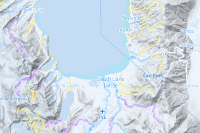

In [9]:
webmap_search = AGOL.content.search(query="Threshold - Fisheries", item_type="Web Map")
webmap_search
webmap = webmap_search[0]
webmap

In [10]:
# display map
fishHabMap = WebMap(webmap)
fishHabMap

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

## Acres Of "Prime" Fish Habitat

In [14]:
marginal = sdfFishHab2016[sdfFishHab2016['Habitat2015']=='Marginal']['Acres'].sum()
feed = sdfFishHab2016[sdfFishHab2016['Habitat2015']=='Feed-Cover']['Acres'].sum()
spawn = sdfFishHab2016[sdfFishHab2016['Habitat2015']=='Spawning']['Acres'].sum()

In [15]:
df = pd.DataFrame([marginal,feed,spawn])

In [16]:
df.index.name

In [26]:
fig = px.bar(df)
fig.update_layout(xaxis_type='category',
                  title_text='Fish Habitat - Nearshore Lake Tahoe',
                  showlegend = False)
fig.update_xaxes(title= 'Habitat',tickfont=dict(family='Calibri', size=14))
fig.update_yaxes(title= 'Acres', tickfont=dict(family='Calibri', size=14))
fig.update_xaxes(
    ticktext=["Marginal", "Feed-Cover", "Spawning"],
    tickvals=["0", "1", "2", df.index.max()],
)
fig.show()

fig.write_html(os.path.join(workspace, "Fisheries_LakeHabitat.html"))

ValueError: Plotly Express cannot process wide-form data with columns of different type.

## Miles Of Stream Habitat In 
* Excellent Stream Condition 
* Good Condition
* Marginal Condition

In [31]:
dfFishStream

,Description,Year,Value
0,Average CSCI score of all trend sites,2010-2011,0.97
1,Average CSCI score of all trend sites,2012-2013,0.93
2,Average CSCI score of all trend sites,2014-2015,0.94
3,Average CSCI score of all trend sites,2016-2019,0.94


In [33]:

df = dfFishStream

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# # create threshold line
# fig.add_trace(go.Scatter(
#     y=df['Threshold Value'],
#     x=df['Year'],
#     name= "Threshold Value",
#     line=dict(color='#337ab7', width=5, dash='dash')
# ))

# # creat trendline
# fig2 = px.scatter(dfComNoise, x = 'Year', y= 'Value', 
#                  trendline='ols', 
#                  trendline_color_override='#279bdc')

# # add trendline to figure
# trendline = fig2.data[1]
# fig.add_trace(trendline)

# update layout
fig.update_layout(title='Fish Stream Habitat - Average Stream Condition Index',
                  showlegend=True)

# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Fisheries_StreamHabitat.html"))

# Noise

## Data

In [61]:
plannoiseXLS = r"F:\Research and Analysis\Threshold reporting\ThresholdData\Noise\ThresholdData_PlanAreaNoise.xlsx"
shorenoiseXLS = r"F:\Research and Analysis\Threshold reporting\ThresholdData\Noise\ThresholdData_ShorelineNoise.xlsx"
dfPlanNoise = pd.read_excel(plannoiseXLS, sheet_name=0)
dfShoreNoise = pd.read_excel(shorenoiseXLS, sheet_name=0)

In [62]:
dfPlanNoise

,Category,Description,Year,Value,Threshold Value
0,Commercial Areas,Average CNEL of all sites during timeframe,1987-1991,55.50,60
1,Commercial Areas,Average CNEL of all sites during timeframe,1992-1996,56.35,60
2,Commercial Areas,Average CNEL of all sites during timeframe,1997-2001,57.90,60
3,Commercial Areas,Average CNEL of all sites during timeframe,2007-2011,52.10,60
4,Commercial Areas,Average CNEL of all sites during timeframe,2012-2015,55.00,60
5,Commercial Areas,Average CNEL of all sites during timeframe,2016-2019,51.12,60
6,High Density Residential,Average CNEL of all sites during timeframe,1987-1991,51.20,55
7,High Density Residential,Average CNEL of all sites during timeframe,1992-1996,49.60,55
8,High Density Residential,Average CNEL of all sites during timeframe,1997-2001,50.20,55
9,High Density Residential,Average CNEL of all sites during timeframe,2007-2011,51.30,55


In [63]:
dfShoreNoise

,Category,Year,Value,Threshold Value
0,Average Exceedances per Day across all sites,2009,0.19,0
1,Average Exceedances per Day across all sites,2010,0.16,0
2,Average Exceedances per Day across all sites,2011,0.24,0
3,Average Exceedances per Day across all sites,2012,0.25,0
4,Average Exceedances per Day across all sites,2013,0.09,0
5,Average Exceedances per Day across all sites,2016,0.34,0
6,Average Exceedances per Day across all sites,2017,0.56,0
7,Average Exceedances per Day across all sites,2019,0.21,0


## Map

In [14]:
webmap_search = AGOL.content.search(query="Threshold - Noise", item_type="Web Map")
webmap_search
webmap = webmap_search[0]
webmap

IndexError: list index out of range

In [ ]:
# display map
noiseMap = WebMap(webmap)
noiseMap

## Commercial Areas

In [76]:
# get commercial area records
dfComNoise = dfPlanNoise.loc[dfPlanNoise['Category'] == 'Commercial Areas']
dfComNoise.astype({'Year': 'str'}).dtypes
df = dfComNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.0f} decibels<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} decibels<extra></extra>'
))


# update layout
fig.update_layout(title='Commercial Area Noise',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[40, 80],
                        title_text='Value (average decibels)'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_Commercial.html"))

## Critical Wildlife Habitat Areas

## High Density Residential Areas

In [88]:
# get commercial area records
dfHighResNoise = dfPlanNoise.loc[dfPlanNoise['Category'] == 'High Density Residential']
dfHighResNoise.astype({'Year': 'str'}).dtypes
df = dfHighResNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.0f} decibels<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} decibels<extra></extra>'
))

# update layout
fig.update_layout(title='High Density Residential Area Noise',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[40, 80],
                        title_text='Value (average decibels)'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_HighDensityResidential.html"))

## Hotel/Motel Areas

In [87]:
# get commercial area records
dfHotelNoise = dfPlanNoise.loc[dfPlanNoise['Category'] == 'Hotel / Motel Areas']
dfHotelNoise.astype({'Year': 'str'}).dtypes
df = dfHotelNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.0f} decibels<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} decibels<extra></extra>'
))

# update layout
fig.update_layout(title= 'Hotel / Motel Area Noise',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[40, 80],
                        title_text='Value (average decibels)'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_HotelMotelAreas.html"))

## Industrial Areas

In [86]:
# get commercial area records
dfIndNoise = dfPlanNoise.loc[dfPlanNoise['Category'] == 'Industrial Areas']
dfIndNoise.astype({'Year': 'str'}).dtypes
df = dfIndNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.0f} decibels<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} decibels<extra></extra>'
))

# update layout
fig.update_layout(title= 'Industrial Area Noise',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[40, 80],
                        title_text='Value (average decibels)'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_IndustrialAreas.html"))

## Low Density Residential Areas

In [85]:
# get commercial area records
dfLowResNoise = dfPlanNoise.loc[dfPlanNoise['Category'] == 'Low Density Residential']
dfLowResNoise.astype({'Year': 'str'}).dtypes
df = dfLowResNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.0f} decibels<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} decibels<extra></extra>'
))

# update layout
fig.update_layout(title= 'Low Density Residential Areas',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[40, 80],
                        title_text='Value (average decibels)'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_LowDensityResidential.html"))

## Rural Outdoor Recreation Areas


In [84]:
# get commercial area records
dfRuralRecNoise = dfPlanNoise.loc[dfPlanNoise['Category'] == 'Rural Outdoor Recreation Areas']
dfRuralRecNoise.astype({'Year': 'str'}).dtypes
df = dfRuralRecNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.0f} decibels<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} decibels<extra></extra>'
))

# update layout
fig.update_layout(title= 'Rural Outdoor Recreation Areas',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[40, 80],
                        title_text='Value (average decibels)'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_RuralRecAreas.html"))

## Urban Outdoor Recreation Areas


In [91]:
# get commercial area records
dfOutdoorRecNoise = dfPlanNoise.loc[dfPlanNoise['Category'] == 'Urban Outdoor Recreation Areas']
dfOutdoorRecNoise.astype({'Year': 'str'}).dtypes
df = dfOutdoorRecNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.0f} decibels<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} decibels<extra></extra>'
))

# update layout
fig.update_layout(title= 'Urban Outdoor Recreation Areas',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[40, 80],
                        title_text='Value (average decibels)'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_UrbanRecAreas.html"))

## Wilderness And Roadless Areas

In [92]:
# get commercial area records
dfWildNoise = dfPlanNoise.loc[dfPlanNoise['Category'] == 'Wilderness and Roadless']
dfWildNoise.astype({'Year': 'str'}).dtypes
df = dfWildNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.0f} decibels<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} decibels<extra></extra>'
))

# update layout
fig.update_layout(title= 'Wilderness and Roadless Area Noise',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[30, 70],
                        title_text='Value (average decibels)'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_WildernessRoadlessAreas.html"))

## Watercraft-Shoreline


In [97]:
# get commercial area records

df = dfShoreNoise 

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Value')

# update popup
fig.update_traces(hovertemplate='%{y:.2f} exceedances per day<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold:<br>%{y:.0f} exceedances per day<extra></extra>'
))

# update layout
fig.update_layout(title= 'Shoreline Noise',
                    font_family=font,
                    template=template,
                    showlegend=True,
                    hovermode="x unified",
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 0.1,
                        range=[-0.1, 1],
                        title_text='Average Exceedances per Day across all sites'
                    )  
                 )
                 


# generate figure
fig.show()
fig.write_html(os.path.join(workspace, "Noise_Shoreline.html"))

# Scenic Resources

## Data

In [4]:
scenicXLS = r"F:\Research and Analysis\Threshold reporting\ThresholdData\Scenic\Master Scenic Threshold Monitoring Data Through 2019.xls"
scenicshoreXLS = r"F:\Research and Analysis\Threshold reporting\ThresholdData\Scenic\Shoreline SQR SR-2 Tab Cleaned Up.xlsx"
dfScenicShore = pd.read_excel(scenicshoreXLS, sheet_name=0)

In [5]:
import xlrd
xls = xlrd.open_workbook(scenicXLS, on_demand=True)
print (xls.sheet_names()) # <- remeber: xlrd sheet_names is a function, not a property

['all', 'ROADWAY TRAVEL ROUTE SR-1', 'SHORELINE TRAVEL ROUTE SR-1', 'ROADWAY SQR SR-2', 'SHORELINE SQR SR-2', 'REC. & BIKE TRAILS SR-3', 'TOTALS']


In [8]:
dfScenic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 10 columns):
Unnamed: 0                            40 non-null int64
Scenic Type                           40 non-null object
Count of Units in Attainment          40 non-null int64
Count of Units Out of Attainment      40 non-null int64
Count of Units N/A                    40 non-null int64
Total Units Assessed                  40 non-null int64
Percent of Units in Attainment        40 non-null float64
Percent of Units Out of Attainment    40 non-null float64
Percent of Units N/A                  40 non-null float64
Total Percent                         40 non-null int64
dtypes: float64(3), int64(6), object(1)
memory usage: 3.2+ KB


In [7]:
dfScenic =  pd.read_excel(scenicXLS, sheet_name='TOTALS')
dfScenic

,Unnamed: 0,Scenic Type,Count of Units in Attainment,Count of Units Out of Attainment,Count of Units N/A,Total Units Assessed,Percent of Units in Attainment,Percent of Units Out of Attainment,Percent of Units N/A,Total Percent
0,1982,ROADWAY TRAVEL ROUTE SR-1,22,24,11,57,0.39,0.42,0.19,1
1,1986,ROADWAY TRAVEL ROUTE SR-1,16,30,0,46,0.35,0.65,0.00,1
2,1991,ROADWAY TRAVEL ROUTE SR-1,16,30,11,57,0.28,0.53,0.19,1
3,1996,ROADWAY TRAVEL ROUTE SR-1,17,29,11,57,0.30,0.51,0.19,1
4,2001,ROADWAY TRAVEL ROUTE SR-1,25,29,3,57,0.44,0.51,0.05,1
5,2006,ROADWAY TRAVEL ROUTE SR-1,26,28,3,57,0.46,0.49,0.05,1
6,2011,ROADWAY TRAVEL ROUTE SR-1,28,26,3,57,0.49,0.46,0.05,1
7,2015,ROADWAY TRAVEL ROUTE SR-1,31,23,4,58,0.53,0.40,0.07,1
8,2019,ROADWAY TRAVEL ROUTE SR-1,31,23,0,54,0.57,0.43,0.00,1
9,1982,SHORELINE TRAVEL ROUTE SR-1,29,4,0,33,0.88,0.12,0.00,1


In [9]:
fig = px.pie(dfScenic, values='Count of Units in Attainment', names='Scenic Type', title='Units in Attainment')
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "Scenic.html"))

## Map

<Item title:"Threshold - Scenic" type:Web Map owner:mbindl>
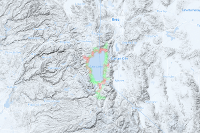

In [15]:
webmap_search = AGOL.content.search(query="Threshold - Scenic", item_type="Web Map")
webmap_search
webmap = webmap_search[0]
webmap

In [16]:
scenicMap = WebMap(webmap)
scenicMap

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

## Restore Roadway Units


## Restore Shoreline Units


## Roadway Travel Routes


## Scenic Quality Of Other Areas (Recreation Sites And Bike Trails)


## Scenic Quality Ratings For Roadway Units 


## Scenic Quality Ratings For Shoreline Units (Scenic Resources)


In [ ]:
dfScenic.info()

In [ ]:
dfScenic['SCENIC RESOURCES'].unique()

In [ ]:
fig = px.pie(dfScenicRoad, values='pop', names='country', title='Population of European continent')
fig.show()

In [22]:
# setup plot
fig = px.scatter(dfScenicRoad, x = 'Year', y= 'Value', color='Site', 
                 color_discrete_map=color_discrete_map,
                 marginal_y='box')

# create threshold line
fig.add_trace(go.Scatter(
    y=dfScenicRoad['Threshold Value'],
    x=dfScenicRoad['Year'],
    name= "Threshold Value",
    line=dict(color='#337ab7', width=5, dash='dash')
))

fig2 = px.scatter(scenicRoad, x = 'Year', y= 'Value', 
                 trendline='ols', trendline_color_override='#279bdc')

trendline = fig2.data[1]

fig.add_trace(trendline)

fig.update_layout(title="Annual Average Pm2.5 Concentration",
                  showlegend=True)

fig.show()

fig.write_html("C:\\GIS\\PROJECT\\ThresholdEvaluation\\AirQuality_PM2_5.html")

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['Camp Richardson', 'EL', 2, 1982, 4, '4.1', '4.2', '2.1', 3, '3.1', 20, 'A', 'Unnamed: 12'] but received: Year

## Shoreline Travel Routes


## Travel Route Ratings For Roadway Units (Scenic Resources)


## Travel Route Ratings For Shoreline Travel Units


# Soil Conservation

In [228]:
# set local variables
tvalspace = "C:\\GIS\PROJECT\\ThresholdEvaluation"

imp2010CSV = os.path.join(tvalspace, "ImperviousOverlayAnalysis_2010.csv")
dfLCImp2010= pd.read_csv(imp2010CSV)

imp2018CSV = os.path.join(tvalspace, "ImperviousOverlayAnalysis_2018.csv")
dfLCImp2018= pd.read_csv(imp2018CSV)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (5,9,15,16,24,26,28,29,30,31,33,36,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,57,59,60,61,67,68,69,71,73,83,84,85,86,87,88,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.



In [270]:
dfLCImp2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296804 entries, 0 to 296803
Data columns (total 98 columns):
OBJECTID                                       296804 non-null int64
FID_id_NRCS_Impervious_LocalPlan_TownCenter    296804 non-null int64
FID_id_NRCS_Impervious_LocalPlan               296804 non-null int64
FID_id_NRCS_Impervious                         296804 non-null int64
FID_land_capability_NRCS2007                   296804 non-null int64
MUSYM                                          296804 non-null object
MUKEY                                          296804 non-null int64
sde_SDE_land_capability_NRCS2007_area          296804 non-null float64
Map_Symbol                                     296804 non-null float64
Land_Capab                                     296804 non-null object
Percent_Al                                     296804 non-null float64
Bailey_Co                                      296804 non-null float64
Allowed_ac                                     2968

In [242]:
df = dfLCImp2010.astype({"Land_Capab": str})
df = df.rename(columns={'Land_Capab':'Land Capability', 'GISAcre':'Total Acres'})
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df[df['Land Capability'].notna()]
df.set_index('Land Capability')
dfLCType = df.groupby("Land Capability")["Total Acres"].sum().reset_index()
dfLCType

,Land Capability,Total Acres
0,1A,"23,544.04"
1,1B,"11,308.73"
2,1C,"53,949.94"
3,2,"23,659.81"
4,3,"16,911.09"
5,4,"32,382.71"
6,5,"10,363.84"
7,6,"24,315.39"
8,7,"5,537.00"


In [243]:
df = dfLCType
df = df.replace(r'^\s*$', np.nan, regex=True)

df = df[df['Land Capability'].notna()]

df['Land Capability']= pd.Categorical(df['Land Capability'], ['1A', '1B', '1C', '2', '3', '4', '5', '6', '7'])

df.sort_values(by="Land Capability")

colors = ['#D1FF73','#FFFF00','#4CE600','#4C7300', 
          '#0084A8', '#FFD37F','#FFAA00','#CD8966', '#734C00']

fig = px.bar(df, y="Land Capability", x="Total Acres", color="Land Capability", 
             orientation="h", 
             hover_name="Land Capability",
             color_discrete_sequence=colors ,
             title="Land Capability"
            )

fig.update_traces(hovertemplate='%{y}<br>%{x:,.0f} acres<extra></extra>')


fig.update_layout(font_family=font,
                    template=template,
                    showlegend=True)
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "SoilConservation_LandCapability.html"))

## Impervious Coverage Analysis Results


In [276]:
df = dfLCImp2010.astype({"Land_Capab": str})
df = df.rename(columns={'Land_Capab':'Land Capability', 'GISAcre':'Acre'})
df.set_index('Land Capability')

pivotSoilImp = pd.pivot_table(df,index=['Land Capability'],
                              columns='Surface',
                              values=['Acre'], 
                              aggfunc=np.sum,fill_value=0)

flattened = pd.DataFrame(pivotSoilImp.to_records())

df = flattened.rename(columns={"('Acre', 'Hard')":'Acres of Hard Surface 2010',
                               "('Acre', 'Soft')":'Acres of Soft Surface 2010'})
df = df.replace(r'^\s*$', np.nan, regex=True)
df["Acres of Coverage 2010"]= df["Acres of Hard Surface 2010"]+df["Acres of Soft Surface 2010"]
df = df[df['Land Capability'].notna()]

df.set_index('Land Capability')

dfMerge = pd.merge(df, dfLCType, on='Land Capability')

df = dfMerge.rename(columns={'Acre':'Total Acres'})
df['Percent Hard 2010'] = (df['Acres of Hard Surface 2010']/df['Total Acres'])*100
df['Percent Soft 2010'] = (df['Acres of Soft Surface 2010']/df['Total Acres'])*100
df['Percent Impervious 2010'] = ((df['Acres of Hard Surface 2010']+df['Acres of Soft Surface 2010'])/df['Total Acres'])*100

df['Threshold Value'] = "0%"
df.loc[df['Land Capability'].isin(['1A','1B','1C','2']), 'Threshold Value'] = "1%"
df.loc[df['Land Capability'].isin(['3']), 'Threshold Value'] = "5%"
df.loc[df['Land Capability'].isin(['4']), 'Threshold Value'] = "20%"
df.loc[df['Land Capability'].isin(['5']), 'Threshold Value'] = "25%"
df.loc[df['Land Capability'].isin(['6','7']), 'Threshold Value'] = "30%"

df['Threshold Acres'] = 0
df.loc[df['Land Capability'].isin(['1A','1B','1C','2']), 'Threshold Acres'] = df['Total Acres']*0.01
df.loc[df['Land Capability'].isin(['3']), 'Threshold Acres'] = df['Total Acres']*0.05
df.loc[df['Land Capability'].isin(['4']), 'Threshold Acres'] = df['Total Acres']*0.2
df.loc[df['Land Capability'].isin(['5']), 'Threshold Acres'] = df['Total Acres']*0.25
df.loc[df['Land Capability'].isin(['6','7']), 'Threshold Acres'] = df['Total Acres']*0.3

df2010 = df
df2010

# 2018 analysis results
df = dfLCImp2018.astype({"Land_Capab": str})
df = df.rename(columns={'Land_Capab':'Land Capability', 'GISAcre':'Acre'})
df.set_index('Land Capability')

# pivot land capbility by acres of surface type
pivotSoilImp = pd.pivot_table(df,index=['Land Capability'],
                              columns='Surface',
                              values=['Acre'], 
                              aggfunc=np.sum,fill_value=0)

flattened = pd.DataFrame(pivotSoilImp.to_records())

df = flattened.rename(columns={"('Acre', 'Hard')":'Acres of Hard Surface 2018',
                               "('Acre', 'Soft')":'Acres of Soft Surface 2018'})

# replace all spaces ond blanks with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df[df['Land Capability'].notna()]

# calculate acres of coverage
df["Acres of Coverage 2018"]= df["Acres of Hard Surface 2018"]+df["Acres of Soft Surface 2018"]

# merge grouped land capability data frame with impervious pivot data frame
dfMerge = pd.merge(df, dfLCType, on='Land Capability')

# rename field
df = dfMerge.rename(columns={'Acre':'Total Acres'})

# calculate perent coverage
df['Percent Hard 2018'] = (df['Acres of Hard Surface 2018']/df['Total Acres'])*100
df['Percent Soft 2018'] = (df['Acres of Soft Surface 2018']/df['Total Acres'])*100
df['Percent Impervious 2018'] = ((df['Acres of Hard Surface 2018']+df['Acres of Soft Surface 2018'])/df['Total Acres'])*100

# record percent allowed field
df['Threshold Value'] = "0%"
df.loc[df['Land Capability'].isin(['1A','1B','1C','2']), 'Threshold Value'] = "1%"
df.loc[df['Land Capability'].isin(['3']), 'Threshold Value'] = "5%"
df.loc[df['Land Capability'].isin(['4']), 'Threshold Value'] = "20%"
df.loc[df['Land Capability'].isin(['5']), 'Threshold Value'] = "25%"
df.loc[df['Land Capability'].isin(['6','7']), 'Threshold Value'] = "30%"

# determine acres of coverage allowed per land capability
df['Threshold Acres'] = 0
df.loc[df['Land Capability'].isin(['1A','1B','1C','2']), 'Threshold Acres'] = df['Total Acres']*0.01
df.loc[df['Land Capability'].isin(['3']), 'Threshold Acres'] = df['Total Acres']*0.05
df.loc[df['Land Capability'].isin(['4']), 'Threshold Acres'] = df['Total Acres']*0.2
df.loc[df['Land Capability'].isin(['5']), 'Threshold Acres'] = df['Total Acres']*0.25
df.loc[df['Land Capability'].isin(['6','7']), 'Threshold Acres'] = df['Total Acres']*0.3

df2018 = df.drop(columns=['Threshold Acres', 'Threshold Value', 'Total Acres'])
df2018

df = pd.merge(df2018, df2010, on='Land Capability')

df['Percent Change'] = df['Percent Impervious 2018']-df['Percent Impervious 2010']

df = df[['Land Capability',
         'Acres of Hard Surface 2010',
         'Acres of Hard Surface 2018',
         'Acres of Soft Surface 2010',
         'Acres of Soft Surface 2018',
         'Acres of Coverage 2010',
         'Acres of Coverage 2018',
         'Percent Hard 2010',
         'Percent Hard 2018',
         'Percent Soft 2010',
         'Percent Soft 2018',
         'Percent Impervious 2010',
         'Percent Impervious 2018',
         'Percent Change',
         'Total Acres',
         'Threshold Value',
         'Threshold Acres']]

df

,Land Capability,Acres of Hard Surface 2010,Acres of Hard Surface 2018,Acres of Soft Surface 2010,Acres of Soft Surface 2018,Acres of Coverage 2010,Acres of Coverage 2018,Percent Hard 2010,Percent Hard 2018,Percent Soft 2010,Percent Soft 2018,Percent Impervious 2010,Percent Impervious 2018,Percent Change,Total Acres,Threshold Value,Threshold Acres
0,1A,74.04,85.45,100.62,208.35,174.66,293.80,0.31,0.36,0.43,0.88,0.74,1.25,0.51,"23,544.04",1%,235.44
1,1B,681.34,715.50,115.41,109.78,796.74,825.28,6.02,6.33,1.02,0.97,7.05,7.30,0.25,"11,308.73",1%,113.09
2,1C,272.62,279.37,246.09,307.05,518.71,586.43,0.51,0.52,0.46,0.57,0.96,1.09,0.13,"53,949.94",1%,539.50
3,2,132.57,158.12,147.45,222.11,280.01,380.23,0.56,0.67,0.62,0.94,1.18,1.61,0.42,"23,659.81",1%,236.60
4,3,187.34,206.54,173.82,266.66,361.15,473.20,1.11,1.22,1.03,1.58,2.14,2.80,0.66,"16,911.09",5%,845.55
5,4,912.61,991.30,356.83,468.18,"1,269.43","1,459.47",2.82,3.06,1.10,1.45,3.92,4.51,0.59,"32,382.71",20%,"6,476.54"
6,5,921.94,971.43,201.54,216.15,"1,123.47","1,187.58",8.90,9.37,1.94,2.09,10.84,11.46,0.62,"10,363.84",25%,"2,590.96"
7,6,"1,855.49","1,966.72",389.89,435.36,"2,245.39","2,402.08",7.63,8.09,1.60,1.79,9.23,9.88,0.64,"24,315.39",30%,"7,294.62"
8,7,"1,166.39","1,217.34",137.28,129.95,"1,303.67","1,347.29",21.07,21.99,2.48,2.35,23.54,24.33,0.79,"5,537.00",30%,"1,661.10"


In [277]:
df['Percent Change'].sum()

4.607543937420224

In [272]:

df['Land Capability']= pd.Categorical(df['Land Capability'], ['1A', '1B', '1C', '2', '3', '4', '5', '6', '7'])

df.sort_values(by="Land Capability")

colors = ['#D1FF73','#FFFF00','#4CE600','#4C7300', 
          '#0084A8', '#FFD37F','#FFAA00','#CD8966', '#734C00']

fig = px.bar(df, x="Land Capability", y="Total Acres", color="Land Capability",  
             hover_name="Land Capability",
             color_discrete_sequence=colors,
             title="Land Capability"
            )

fig.update_traces(hovertemplate='Land Capability %{x}<br>%{y:,.0f} acres<extra></extra>')

# create threshold lines
fig.add_trace(go.Scatter(
    y=df['Threshold Acres'],
    x=df['Land Capability'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='markers',
    marker_symbol='line-ew',
    marker_line_color="midnightblue", 
    marker_color="lightskyblue", 
    marker_line_width=2, 
    marker_size = 36,
    customdata=df['Threshold Value'],
    hovertemplate='Threshold:<br>%{customdata} coverage allowed<br>or %{y:,.0f} acres<extra></extra>'
))

# create coverage bars
fig.add_trace(go.Bar(
    y=df['Acres of Coverage 2010'],
    x=df['Land Capability'],
    name= "Coverage 2010",
    marker_color='rgb(158,202,225)', 
    marker_line_color='rgb(8,48,107)',
    opacity=0.6,
    hovertemplate='%{y:,.0f} acres covered 2010<extra></extra>'
))

# create coverage bars
fig.add_trace(go.Bar(
    y=df['Acres of Coverage 2018'],
    x=df['Land Capability'],
    name= "Coverage 2018",
    marker_color='rgb(188,202,200)', 
    marker_line_color='rgb(88,48,10)',
    opacity=0.6,
    hovertemplate='%{y:,.0f} acres covered 2018<extra></extra>'
))


fig.update_layout(font_family=font,
                    template=template,
                    showlegend=True,
                    barmode='overlay',
                    title='Land Capability and Impervious Coverage')
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "SoilConservation_LandCapability_Coverage.html"))

## Preserve Stream Environment Zone (SEZ) Function, Restore Undeveloped SEZ

# Vegetation

## Data

In [109]:
dfTYC = pd.read_csv(r"F:\Research and Analysis\Threshold reporting\ThresholdData\Vegetation\TYC Appendix C 2019Revised.csv")

In [110]:
# set environment variables
arcpy.env.workspace = r'C:/GIS/PROJECT/ForestHealth/Data/ForestHealth_ThresholdData.gdb'
scratchFolder = r'C:/GIS/PROJECT/ForestHealth/Data'
# set local variables
Ecobject = r'C:/GIS/PROJECT/ForestHealth/Data/ForestHealth_ThresholdData.gdb/Ecobject_LakeTahoeBasin'

In [111]:
dfVeg = pd.read_csv(os.path.join(workspace, "Vegetation_Ecobject_2010.csv"))

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (11,104) have mixed types. Specify dtype option on import or set low_memory=False.



### 2010 Vegetation Abundance

In [126]:
dfVegType = dfVeg.groupby("TRPA_VegTy")["Acres"].sum().reset_index()
df = dfVegType.rename(columns={'TRPA_VegTy':'Vegetation Type'})
colors = ['#d7d79e','#9ed7c2','#cdf57a','#b4d79e', 
          '#ff0000', '#a5f57a','#00a820','#df73ff', 
          '#3e72b0','#2f3f56', '#a8a800']

fig = px.bar(df, y="Vegetation Type", x="Acres", color="Vegetation Type", orientation="h", hover_name="Vegetation Type",
             color_discrete_sequence=colors ,
             title="Vegetation Abundance"
            )

fig.update_traces(hovertemplate='%{y}<br>%{x:,.0f} acres<extra></extra>')


fig.update_layout(font_family=font,
                    template=template,
                    showlegend=True,
                    yaxis={'categoryorder':'total ascending'})
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "Vegetation_Abundance_2010.html"))

## Relative Abundance Of Meadows And Wetland Vegetation Types

In [145]:
dfVegType = dfVeg.groupby("TRPA_VegTy")["Acres"].sum().reset_index()
df = dfVegType.rename(columns={'TRPA_VegTy':'Vegetation Type'})
colors = ['#d7d79e','#9ed7c2','#cdf57a','#b4d79e', 
          '#ff0000', '#a5f57a','#00a820','#df73ff', 
          '#3e72b0','#2f3f56', '#a8a800']

fig = px.pie(df, names="Vegetation Type", values="Acres", color="Vegetation Type", 
             hover_name="Vegetation Type",
             color_discrete_sequence=colors ,
             title="Relative Abundance"
            )

# update figure
fig.update_traces(customdata= df['Acres'],
                  hovertemplate='<br>%{customdata:,.0f} acres<extra></extra>',
                  textposition='inside', 
                  textinfo='percent+label', pull=[0, 0, 0,0,0,0,0,0.2,0])

fig.update_layout(font_family=font,
                    template=template,
                    showlegend=True,
                    yaxis={'categoryorder':'total ascending'})
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "Vegetation_RelativeAbundance_2010.html"))

## Relative Abundance Of Deciduous Riparian Vegetation

## Relative Abundance Of Shrub Vegetation Type

## Relative Abundance Of Yellow Pine Forest In Seral Stages Other Than Mature

## Relative Abundance Of Red Fir Forest In Seral Stages Other Than Mature

## Montane Old Growth, Sub-Alpine Old Growth, Total Old Growth, Upper Montane Old Growth

## Deepwater Plants Of Lake Tahoe

##  Freel Peak Cushion Plant Community

## Tahoe Yellow Cress (Rorippa Subumbellata)

### Map

<Item title:"Threshold - Vegetation - Tahoe Yellow Cress" type:Web Map owner:mbindl>
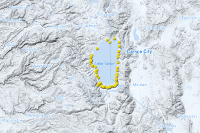

In [20]:
webmap_search = AGOL.content.search(query="Threshold - Vegetation - Tahoe Yellow Cress")
webmap = webmap_search[0]
webmap

In [21]:
tycMap = WebMap(webmap)
tycMap

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

### Data

In [146]:
dfTYC = pd.read_csv(r"F:\Research and Analysis\Threshold reporting\ThresholdData\Vegetation\TYC Appendix C 2019Revised.csv")

In [150]:
fig = px.bar(dfTYC, x='Year', y='Number of Occupied Sites')

fig.update_traces(marker_color='#ffffbf', 
                  marker_line_color="#8a7121",
                  marker_line_width=1.5, 
                  opacity=0.6,
                  hovertemplate='<br>%{y:,.0f} occupied sites<extra></extra>'
                 )

fig.update_layout(font_family=font,
                    template=template,
                    showlegend=True,
                    title_text='Tahoe Yellow Cress', 
                    hovermode="x")

fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "Vegetation_TahoeYellowCress.html"))

# Water Quality

## Nearshore Turbidity (No Stream Influence), Nearshore Turbidity (Stream Influence)

## Nearshore Attached Algae, Nearshore Periphyton Biomass 

## Aquatic Invasive Species Abundance, Distribution, Ecological Impacts, Economic Impacts, Public Health Impacts, Social  Impacts

# Wildlife

In [5]:
waterfowlXLS = r"F:\Research and Analysis\Threshold reporting\ThresholdData\Wildlife\Waterfowl_HumanActivityRating_2019.xlsx"
dfWaterfowl = pd.read_excel(waterfowlXLS, sheet_name=0)

wildlifeXLS = r"F:\Research and Analysis\Threshold reporting\ThresholdData\Wildlife\Wildlife_ThresholdData.xlsx"
dfWildlife = pd.read_excel(wildlifeXLS, sheet_name=0)

In [6]:
dfWildlife['Wildlife Species'].unique()

array(['Bald Eagle - winter', 'Bald Eagle - nesting', 'Northern Goshawk',
       'Osprey', 'Peregrine Falcon', 'Waterfowl'], dtype=object)

##  Northern Goshawk Population Sites

In [23]:
dfGoshawk = dfWildlife.loc[dfWildlife['Wildlife Species'] == 'Northern Goshawk']

df=dfGoshawk
# setup plot
fig = px.scatter(df, x = 'Year', y= 'Count', color='Wildlife Species')

# update popup
fig.update_traces(customdata=df['Wildlife Species'],
                  hovertemplate='%{y:.0f} %{customdata} nests<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold: %{y:.0f}<extra></extra>'
))

# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Count', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
df['Beta'] = fit_results.params[1]

# create variable of beta
slope = df['Beta']

trendline.update(showlegend=True, name="Trend", line_width=3,
                customdata=slope, hovertemplate='Trend: %{customdata:.2f}<extra></extra>'
                )

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title='Northern Goshawk Nest Sites',
                    font_family=font,
                    template=template,
                    hovermode="x unified",
                    showlegend=True,
                    xaxis = dict(
                        tickmode = 'linear',
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[0, 20],
                        title_text='Nest Sites'
                    )       
                 )

# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "Wildlife_Goshawk_NestSites.html"))

Beta = -0.0276679841897174


##  Osprey Population Sites

In [35]:
# setup dataframe
df = dfWildlife.loc[dfWildlife['Wildlife Species'] == 'Osprey']

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Count', color='Wildlife Species')

# update popup
fig.update_traces(customdata=df['Wildlife Species'],
                  hovertemplate='%{y:.0f} %{customdata} nests<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold: %{y:.0f}<extra></extra>'
))

# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Count', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
df['Beta'] = fit_results.params[1]

# create variable of beta
slope = df['Beta']

# update trendline legend and popup
trendline.update(showlegend=True, name="Trend", line_width=3,
                  customdata=slope, 
                  hovertemplate='Trend: %{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title='Osprey Nest Sites',
                    font_family=font,
                    template=template,
                    hovermode="x unified",
                    showlegend=True,
                    xaxis = dict(
                        tickmode = 'linear',
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[0, 40],
                        title_text='Nest Sites'
                    )       
                 )

# show figure
fig.show()

# save to HTML
fig.write_html(os.path.join(workspace, "Wildlife_Osprey_NestSites.html"))

Beta = 0.41996047430830385


## Wintering Bald Eagle Population Sites

In [29]:
# setup dataframe
df = dfWildlife.loc[dfWildlife['Wildlife Species'] == 'Bald Eagle - winter']

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Count', color='Wildlife Species')

# update popup
fig.update_traces(customdata=df['Wildlife Species'],
                  hovertemplate='%{y:.0f} %{customdata} nests<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold: %{y:.0f}<extra></extra>'
))

# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Count', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
df['Beta'] = fit_results.params[1]

# create variable of beta
slope = df['Beta']

# update trendline legend and popup
trendline.update(showlegend=True, name="Trend", line_width=3,
                  customdata=slope, 
                  hovertemplate='Trend: %{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title='Bald Eagel Winter Nesting Sites',
                    font_family=font,
                    template=template,
                    hovermode="x unified",
                    showlegend=True,
                    xaxis = dict(
                        tickmode = 'linear',
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 5,
                        range=[0, 40],
                        title_text='Nest Sites'
                    )       
                 )

# show figure
fig.show()

# save to HTML
fig.write_html(os.path.join(workspace, "Wildlife_BaldEagle_Winter_NestSites.html"))

Beta = 0.6956521739130483


In [57]:
df['Threshold Value'].unique()

array([nan])

##  Nesting Bald Eagle Population Sites

In [32]:
# setup dataframe
df= dfWildlife.loc[dfWildlife['Wildlife Species'] == 'Bald Eagle - nesting']

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Count', color='Wildlife Species')

# update popup
fig.update_traces(customdata=df['Wildlife Species'],
                  hovertemplate='%{y:.0f} %{customdata} sites<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold: %{y:.0f}<extra></extra>'
))

# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Count', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
df['Beta'] = fit_results.params[1]

# create variable of beta
slope = df['Beta']

# update trendline legend and popup
trendline.update(showlegend=True, name="Trend", line_width=3,
                  customdata=slope, 
                  hovertemplate='Trend: %{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)

# set layout
fig.update_layout(title='Bald Eagle Summer Nest Sites',
                    font_family=font,
                    template=template,
                    hovermode="x unified",
                    showlegend=True,
                    xaxis = dict(
                        tickmode = 'linear',
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1,
                        range=[0, 5],
                        title_text='Nest Sites'
                    )       
                 )
# show figure
fig.show()
# save to HTML
fig.write_html(os.path.join(workspace, "Wildlife_BaldEagle_NestSites.html"))

Beta = 0.036086956521740106


##  Peregrine Falcon Population Sites

In [34]:
# setup dataframe
df = dfWildlife.loc[dfWildlife['Wildlife Species'] == 'Peregrine Falcon']

# setup plot
fig = px.scatter(df, x = 'Year', y= 'Count', color='Wildlife Species')

# update popup
fig.update_traces(customdata=df['Wildlife Species'],
                  hovertemplate='%{y:.0f} %{customdata} nest sites<extra></extra>')

# create threshold line
fig.add_trace(go.Scatter(
    y=df['Threshold Value'],
    x=df['Year'],
    name= "Threshold",
    line=dict(color='#333333', width=3),
    mode='lines',
    hovertemplate='Threshold: %{y:.0f}<extra></extra>'
))

# create trendline
fig2 = px.scatter(df, x = 'Year', y= 'Count', 
                 trendline='ols', trendline_color_override='#8a7121')

# set up trendline trace
trendline = fig2.data[1]

# get ols results
fit_results = px.get_trendline_results(fig2).px_fit_results.iloc[0]
# get beta value
beta = fit_results.params[1]
print("Beta = " + str(fit_results.params[1]))
# add beta value from trend line to data frame
df['Beta'] = fit_results.params[1]

# create variable of beta
slope = df['Beta']

# update trendline legend and popup
trendline.update(showlegend=True, name="Trend", line_width=3,
                  customdata=slope, 
                  hovertemplate='Trend: %{customdata:.2f}<extra></extra>')

# add to figure
fig.add_trace(trendline)
# set layout
fig.update_layout(title=' Peregrine Falcon Nest Sites',
                    font_family=font,
                    template=template,
                    hovermode="x unified",
                    showlegend=True,
                    xaxis = dict(
                        tickmode = 'linear',
                        tick0=1985,
                        dtick = 5
                    ),
                    yaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1,
                        range=[0, 6],
                        title_text='Nest Sites'
                    )       
                 )

# show figure
fig.show()

# save to HTML
fig.write_html(os.path.join(workspace, "Wildlife_ PeregrineFalcon_NestSites.html"))

Beta = 0.45104895104894027


## Waterfowl

In [36]:
dfWaterfowl

,Human Disturbance Rating,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Comments
0,#,Site Name,Year,nan,nan,nan,NaN
1,NaN,NaN,2019,"2,015.00","2,011.00","2,001.00",NaN
2,2,Blackwood Canyon,2,2.00,2.00,3.00,NaN
3,3,Bliss Pond,2,2.00,2.00,2.00,NaN
4,4,Edgewood Golf Course,4,4.00,4.00,4.00,NaN
5,5,Fannette Island,4,4.00,4.00,nan,NaN
6,6,Grass Lake,1,1.00,1.00,1.00,NaN
7,7,Lake Baron,3,3.00,4.00,4.00,NaN
8,8,Lake Christopher,2,2.00,2.00,2.00,NaN
9,9,Lily Lake,1,1.00,1.00,1.00,NaN
